In [226]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as sciint
from functools import partial
import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential
from wilson_cowan_2d.analysis.nulclines import calc_cross_points, calc_nulclines_crosspoints

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
report_path = "/home/nicolasjudd/school_notes/neural/final_report/"
img_path = os.path.join(report_path, 'img')

In [228]:
def plot_normalized_response(uinits, ress):
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    _ = [ax[0].plot(u, label=f"Peak={max(u)}") for u in uinits]
    _ = ax[0].set_title(f"Input: Len->{np.sum(uinits[0]>0)}")

    _ = ax[1].set_title("Normalized U Immediate Response")
    _ = ax[2].set_title("Normalized V Immediate Response")
    for res, uinit in zip(ress, uinits):
        udata = res.u[0]
        zu_data = (udata - np.average(udata))/np.std(udata)

        vdata = res.v[0]
        zv_data = (vdata - np.average(vdata))/np.std(vdata)
        x_rang = np.linspace(-zu_data.size//2, zu_data.size//2, zu_data.size)
        
        _ = ax[1].plot(x_rang, zu_data, label=f"Normalized U Immediate Response <- Uinit Peak:{max(res.u[1])}")
        _ = ax[2].plot(x_rang, zv_data, label=f"Normalized V Immediate Response <- Uinit Peak:{max(res.v[1])}")
    
    return fig, ax
    # plt.legend()

In [229]:
def make_s_func(l):
    def s(x):
        return (1/(1 + np.exp(-(x+l/2)/(0.25)))*(1 - 1/(1 + np.exp(-(x-l/2)/(0.25)))))
    return s

In [225]:
τ = 0.15
τe = 0.1
τi = τ * τe

σ = 2# 7.6625  # .6625
σe = 1
σi = σ* σe



A = np.array(( [1.5, 1]
              ,[0.5, 0.1]))
Θ = np.array([0.125, 0.4])

# A = np.array(( [2.15, 1.9]
#               ,[1.6, 1.2]))
# Θ = np.array([-.05, -0.05])


# A = np.array(( [1.35, 0.2]
#               ,[1.8, 0.1]))
# Θ = np.array([-.05, -0.05])

l = 256

param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=3, k=1
                             , size = 2**9+1, σ=np.array([σe,σi])
                            ,A=A, Θ=Θ)


def make_input(intensity, exp, off):
    u = np.zeros(param.size).reshape((param.size,1))
    v = np.zeros(param.size).reshape((param.size, 1))
    
    ii = param.size//2
    u[ii-2**exp + off:ii+2**exp+1 - off] = intensity
    return (u, v)




def make_current(intensity, ss):
    s = make_s_func(l)
    
    t1 = -intensity*1.25 * s(np.arange(-param.size//2, param.size//2)).reshape((param.size,1))
    t2 = -intensity*0.4 * s(np.arange(-param.size//2, param.size//2)).reshape((param.size,1))
    
    t1 = np.min(np.array((t1, -ss*np.ones_like(t1))), axis=0)
    t2 = np.min(np.array((t2, -ss*np.ones_like(t2))), axis=0)

    # ii = param.size//2
    # u[ii-2**exp + off:ii+2**exp+1 - off] = intensity
    # u[ii-2**exp + off:ii+2**exp+1 - off] = intensity
    return np.array((t1, t2))


# intensities = np.linspace(0.1, 1, 10)
# inps = [make_input(i, exp=6, off=0) for i in intensities]
# uinits = [u for (u, _) in inps]


intensities = np.linspace(0.1, 10, 10)
currents = [make_current(i, 1) for i in intensities]
uinits = [u for (u, _) in currents]

u = np.zeros(param.size).reshape((param.size,1))
v = np.zeros(param.size).reshape((param.size, 1)) 
inp = make_input(30, 4, 0)


ress = list()
for cur in currents:
    param.Θ = cur
    # print(param.Θ)
    trv_wav = wck.WCReflectDecExpTravelNonLocal1D(inp, param)

    end = 100
    step = 1/15
    res = trv_wav((0, end), t_eval=np.arange(0, end, step))

    # print(res._solved.message)
    ress.append(res)

# ress = list()
# for inp in inps:
#     trv_wav = wck.WCReflectDecExpTravelNonLocal1D(inp, param)

#     end = 50
#     step = 1/15
#     res = trv_wav((0, end), t_eval=np.arange(0, end, step))

#     # print(res._solved.message)
#     ress.append(res)


# fig = plt.figure()
# _ = plt.imshow(res.u.T, vmin=0, vmax=1)

NameError: name 'make_s_func' is not defined

/tmp/ipykernel_179751/2135298442.py:13: RuntimeWarning: invalid value encountered in divide
  zv_data = (vdata - np.average(vdata))/np.std(vdata)


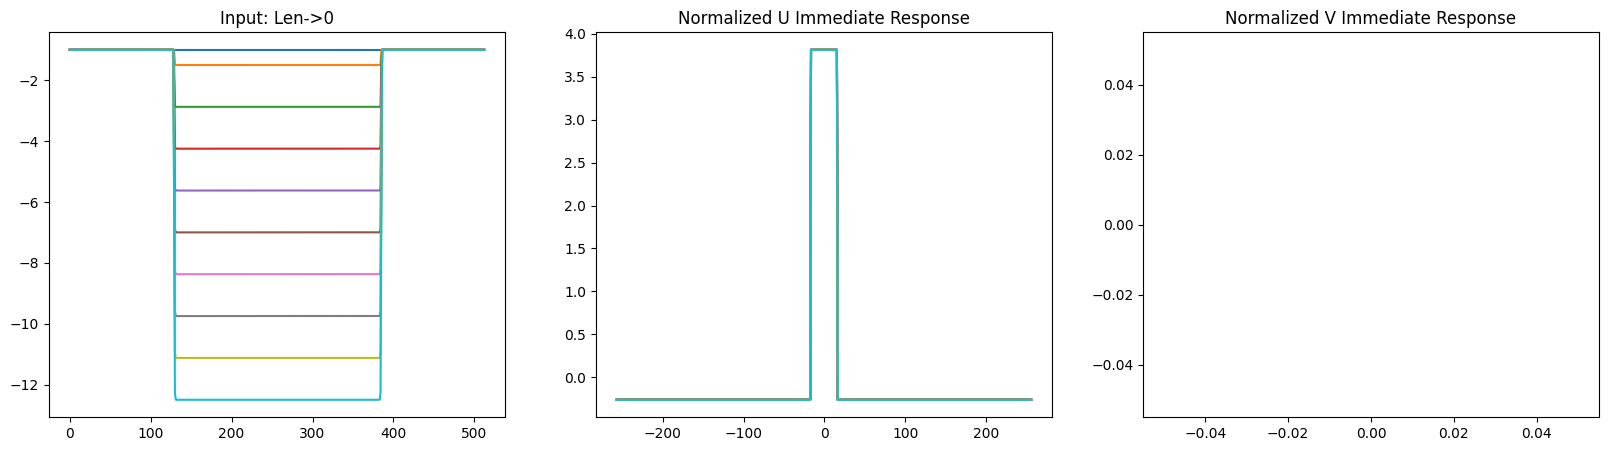

In [96]:
fig, ax = plot_normalized_response(uinits, ress)
# plt.savefig(os.path.join(img_path, f'ssn1d_sig={σ}_tau={τ}_normalized_graph.png')
#             ,bbox_inches='tight')

In [616]:
τ = 0.76
τe = 1
τi = τ * τe

σ = 0.001 # 7.6625  # .6625
σe = 1
σi = σ* σe


n = 3
k = 2
# τe = 1
# σe = 1
A = np.array(( [1.1, 0.25]
                  ,[1, 0.11]))
Θ = np.array([-0.25, -0.1])



param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=3, k=2
                             , size = 2**9+1, σ=np.array([σe,σi]), A=A, Θ=Θ )

u = np.zeros(param.size).reshape((param.size,1))
v = np.zeros(param.size).reshape((param.size, 1))

u[0:2**4] = 1
v[param.size//2:param.size//2 + 2**4] = 0

inp = (u,v)



trv_wav = wck.WCReflectDecExpTravelNonLocal1D(inp, param)

end = 100
step = 1/15
res = trv_wav((0, end), t_eval=np.arange(0, end, step))

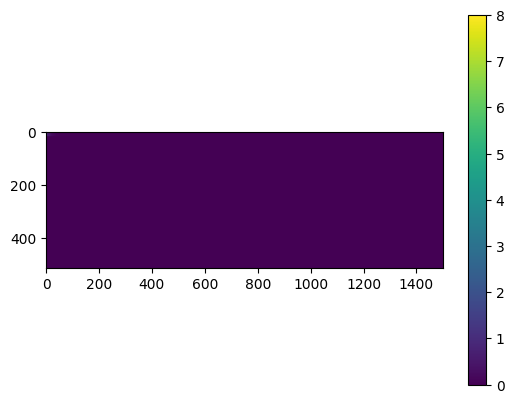

In [617]:
fig = plt.figure()  #(figsize=(16,4))

_ = plt.imshow(res.u.T, vmin = 0, vmax=8)
_ = plt.colorbar()

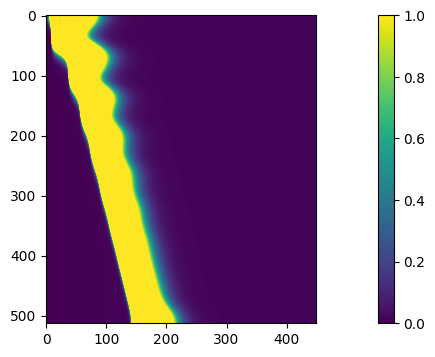

In [537]:
fig = plt.figure(figsize=(16,4))
_ = plt.imshow(res.v.T, vmin = 0, vmax=1)
_ = plt.colorbar()

In [97]:
# gen = zip(uinits, ress)

In [98]:
# u, r = next(gen)
# plot_normalized_response(u, r)

In [99]:
# data = np.average(res.u, axis=0)
# zdata = (data - np.average(data))/np.std(data)
# _ = plt.plot(zdata)


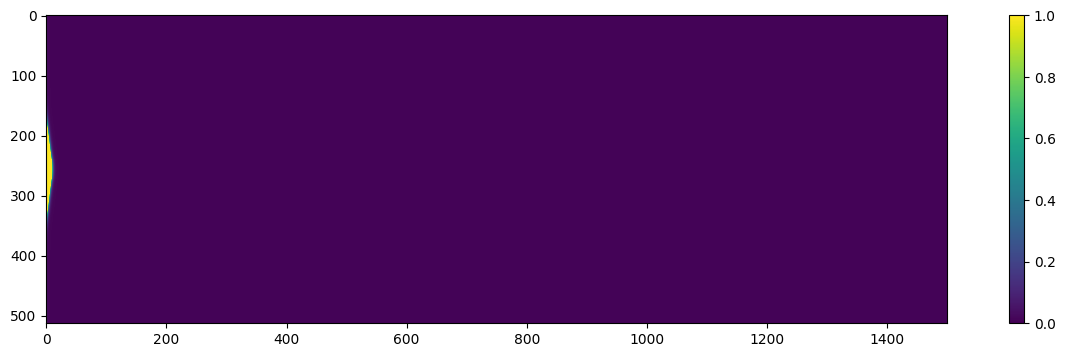

In [100]:
fig = plt.figure(figsize=(16,4))
_ = plt.imshow(ress[0].u.T, vmin = 0, vmax=1)
_ = plt.colorbar()
# plt.savefig(os.path.join(img_path, f'ssn1d_sig={σ}_tau={τ}_max_intensity_display_graph.png')
#                         ,bbox_inches='tight')

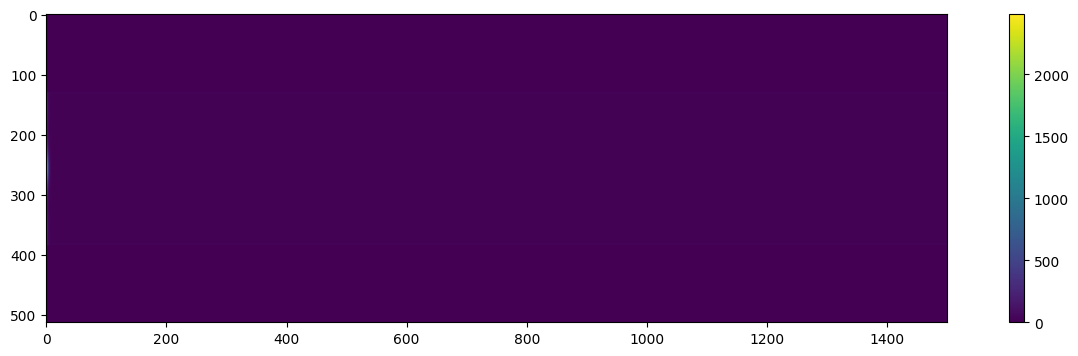

In [89]:
fig = plt.figure(figsize=(16,4))
_ = plt.imshow(ress[9].v.T, vmin=0)
_ = plt.colorbar()
# plt.savefig(os.path.join(img_path, f'ssn1d_sig={σ}_tau={τ}_max_intensity_display_graph.png')
#                         ,bbox_inches='tight')

In [415]:
_ = plt.plot(res.t, res.u[:, param.size])

IndexError: index 513 is out of bounds for axis 1 with size 513